In [293]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys

from seaborn import residplot
from scipy.stats import pearsonr
from scipy.stats.mstats import kruskalwallis
from scikit_posthocs import posthoc_dunn
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

sys.path.append("/kvh4/optic_disc/scripts") 
from training import train_dice, train_bce, train_dice_MC, run_inference, run_MC_inference
from evaluation_functions import compute_dice_dataset, \
                                    compute_mean_uncertainty_dataset, compute_mean_pw_dice_dataset

In [3]:
gt_dir_ng = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
gt_dir_g = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/ground_truth"

In [4]:
filepath = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training"
with open(os.path.join(filepath, "dataset_splits_nonglaucoma_600_100.pkl"), 'rb') as file:
    data_dict = pickle.load(file)

In [5]:
glaucoma_image_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/images"
glaucoma_images = [os.path.join(glaucoma_image_dir, g) for g in os.listdir(glaucoma_image_dir)]
glaucoma_gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/ground_truth"
glaucoma_gt = [os.path.join(glaucoma_gt_dir, g) for g in os.listdir(glaucoma_gt_dir)]

In [6]:
def eval_mean_uncertainty(gt_dir_ng, gt_dir_g, pred_dir_training, pred_dir_test, pred_dir_g, sampling=False):
    evaluation_data_dir = dict() # contains the dice scores and everything from the three datasets 
    
    train_names = [n[-9:-4] for n in os.listdir(pred_dir_training)]
    test_names = [n[-9:-4] for n in os.listdir(pred_dir_test)]
    g_names = [n[-9:-4] for n in os.listdir(pred_dir_g)]
    
    # training data 
    res_train = compute_dice_dataset(train_names, gt_dir_ng, pred_dir_training, mode="cup", sampling=sampling)
    unc_train = compute_mean_uncertainty_dataset(train_names, pred_dir_training, sampling=sampling)
    if sampling:
        pw_train = compute_mean_pw_dice_dataset(train_names, pred_dir_training)

    dice_train = list()
    ms_unc_train = list()
    if sampling:
        pw_dice_train = list()
    for k in res_train.keys():
        dice_train.append(res_train[k])
        ms_unc_train.append(unc_train[k])
        if sampling:
            pw_dice_train.append(pw_train[k])
    evaluation_data_dir["train_dice"] = dice_train
    evaluation_data_dir["train_ms"] = ms_unc_train
    if sampling:
        evaluation_data_dir["train_pw"] = pw_dice_train
    
    # test data 
    res_test = compute_dice_dataset(test_names, gt_dir_ng, pred_dir_test, mode="cup", sampling=sampling)
    unc_test = compute_mean_uncertainty_dataset(test_names, pred_dir_test, sampling=sampling)
    if sampling:
        pw_test = compute_mean_pw_dice_dataset(test_names, pred_dir_test)

    dice_test = list()
    ms_unc_test = list()
    if sampling:
        pw_dice_test = list()
     
    for k in res_test.keys():
        dice_test.append(res_test[k])
        ms_unc_test.append(unc_test[k])
        if sampling:
            pw_dice_test.append(pw_test[k])
    
    evaluation_data_dir["test_dice"] = dice_test
    evaluation_data_dir["test_ms"] = ms_unc_test
    if sampling:
        evaluation_data_dir["test_pw"] = pw_dice_test
    
    # glaucoma data 
    res_g = compute_dice_dataset(g_names, gt_dir_g, pred_dir_g, mode="cup", sampling=sampling)
    unc_g = compute_mean_uncertainty_dataset(g_names, pred_dir_g, sampling=sampling)
    if sampling:
        pw_g = compute_mean_pw_dice_dataset(g_names, pred_dir_g)

    dice_g = list()
    ms_unc_g = list()
    if sampling:
        pw_dice_g = list()
     
    for k in res_g.keys():
        dice_g.append(res_g[k])
        ms_unc_g.append(unc_g[k])
        if sampling:
            pw_dice_g.append(pw_g[k])
    
    evaluation_data_dir["glaucoma_dice"] = dice_g
    evaluation_data_dir["glaucoma_ms"] = ms_unc_g
    if sampling:
        evaluation_data_dir["glaucoma_pw"] = pw_dice_g
    
    
    return evaluation_data_dir

In [7]:
def plot_scatter(eval_dict, sampling=False):
    if sampling:
        plt.subplots(1,2, figsize=(15,5))
        plt.subplot(1,2,1)
    # compute correlations
    plt.scatter(eval_dict["train_dice"], eval_dict["train_ms"], \
                label="training, "+str(round(pearsonr(eval_dict["train_dice"], eval_dict["train_ms"])[0],2)), c="blue")
    plt.scatter(eval_dict["test_dice"], eval_dict["test_ms"], \
                label="test, "+str(round(pearsonr(eval_dict["test_dice"], eval_dict["test_ms"])[0],2)), c="orange")
    plt.scatter(eval_dict["glaucoma_dice"], eval_dict["glaucoma_ms"], \
                label="glaucoma, "+str(round(pearsonr(eval_dict["glaucoma_dice"], eval_dict["glaucoma_ms"])[0],2)),c="green")
    plt.xlabel("Dice score")
    plt.ylabel("Mean uncertainty")
    plt.legend()
    
    if sampling:
        plt.subplot(1,2,2)
        plt.scatter(eval_dict["train_dice"], eval_dict["train_pw"], \
                label="training, "+str(round(pearsonr(eval_dict["train_dice"], eval_dict["train_pw"])[0],2)), c="blue")
        plt.scatter(eval_dict["test_dice"], eval_dict["test_pw"], \
                    label="test, "+str(round(pearsonr(eval_dict["test_dice"], eval_dict["test_pw"])[0],2)), c="orange")
        plt.scatter(eval_dict["glaucoma_dice"], eval_dict["glaucoma_pw"], \
                    label="glaucoma, "+str(round(pearsonr(eval_dict["glaucoma_dice"], eval_dict["glaucoma_pw"])[0],2)), c="green")
        plt.xlabel("Dice score")
        plt.ylabel("Mean pw Dice")
        plt.legend()

In [8]:
def seg_performance(eval_dict):
    print("Training: ", round(np.mean(eval_dict["train_dice"]),2))
    print("Test: ", round(np.mean(eval_dict["test_dice"]),2))
    print("Glaucoma: ", round(np.mean(eval_dict["glaucoma_dice"]),2))

In [181]:
def check_residuals(eval_dict, sampling=False):
    if sampling:
        r = 2 # define number of rows
        plt.subplots(r,3,figsize=(20,10))
    else:
        r = 1 # define number of rows
        plt.subplots(r,3, figsize=(20,5))
    
    plt.subplot(r,3,1)
    residplot(eval_dict["train_dice"], eval_dict["train_ms"], label="training")
    plt.xlabel("Dice")
    plt.ylabel("residuals, ms")
    plt.legend()
    plt.subplot(r,3,2)
    residplot(eval_dict["test_dice"], eval_dict["test_ms"], label="test (in)")
    plt.xlabel("Dice")
    plt.ylabel("residuals, ms")
    plt.legend()
    plt.subplot(r,3,3)
    residplot(eval_dict["glaucoma_dice"], eval_dict["glaucoma_ms"], label="glaucoma")
    plt.xlabel("Dice")
    plt.ylabel("residuals, ms")
    plt.legend()
    
    if sampling:
        plt.subplot(r,3,4)
        residplot(eval_dict["train_dice"], eval_dict["train_pw"], label="training")
        plt.xlabel("Dice")
        plt.ylabel("residuals, pw")
        plt.legend()
        plt.subplot(r,3,5)
        residplot(eval_dict["test_dice"], eval_dict["test_pw"], label="test (in)")
        plt.xlabel("Dice")
        plt.ylabel("residuals, pw")
        plt.legend()
        plt.subplot(r,3,6)
        residplot(eval_dict["glaucoma_dice"], eval_dict["glaucoma_pw"], label="glaucoma")
        plt.xlabel("Dice")
        plt.ylabel("residuals, pw")
        plt.legend()

In [220]:
a= np.concatenate((np.expand_dims(np.array(dice_ensemble["train_pw"]), axis=1),np.expand_dims(np.array(dice_ensemble["train_pw"]), axis=1)), axis=1)

In [221]:
a.shape

(600, 2)

In [259]:
def regression(eval_dict, params, train_on_test=False):

    X_train = np.expand_dims(np.array(eval_dict[params[0]]), axis=1)
    X_test = np.expand_dims(np.array(eval_dict[params[1]]), axis=1)
    X_glaucoma = np.expand_dims(np.array(eval_dict[params[2]]), axis=1)

    if len(params)>3:
        X_train = np.concatenate((X_train, np.expand_dims(np.array(eval_dict[params[3]]), axis=1)), axis=1)
        X_test = np.concatenate((X_test, np.expand_dims(np.array(eval_dict[params[4]]), axis=1)), axis=1)
        X_glaucoma = np.concatenate((X_glaucoma, np.expand_dims(np.array(eval_dict[params[5]]), axis=1)), axis=1)
           
    y_train = np.array(eval_dict["train_dice"])
    y_test = np.array(eval_dict["test_dice"])
    y_glaucoma = np.array(eval_dict["glaucoma_dice"])

    regr = linear_model.LinearRegression()
    if not train_on_test:
        regr.fit(X_train, y_train)
    else: 
        regr.fit(X_test, y_test)

    # Make predictions using the test sets
    if not train_on_test:
        test_pred = regr.predict(X_test)
    glaucoma_pred = regr.predict(X_glaucoma)
    
    # The coefficients
    print('Coefficients: \n', regr.coef_)
    if not train_on_test:
        # The mean squared error
        print('Mean squared error test: %.4f'
              % mean_squared_error(y_test, test_pred))
        print('Mean absolute error test: %.4f'
              % mean_absolute_error(y_test, test_pred))
    print('Mean squared error glaucoma: %.4f'
          % mean_squared_error(y_glaucoma, glaucoma_pred))
    print('Mean absolute error glaucoma: %.4f'
          % mean_absolute_error(y_glaucoma, glaucoma_pred))
    # The coefficient of determination: 1 is perfect prediction
    if not train_on_test:
        print('Coefficient of determination (in domain test): %.2f'
              % r2_score(y_test, test_pred))
    print('Coefficient of determination (glaucoma): %.2f'
          % r2_score(y_glaucoma, glaucoma_pred))

    X_plot = np.linspace(0.1, 1, 100)
    plt.plot(X_plot, X_plot, color='r')
    if not train_on_test: 
        plt.scatter(y_test, test_pred, color='orange', label="in-domain test")
    plt.scatter(y_glaucoma, glaucoma_pred, color='green', label="glaucoma")
    plt.ylabel("predicted Dice score")
    plt.xlabel("true Dice score")
    # plt.ylim([0.6,1])
    # plt.xlim([0.6,1])
    plt.legend()
    plt.show()

## bce vanilla

In [9]:
model_dir = "/kvh4/optic_disc/models/bce_ensemble/00_UNet_cup"
eval_epoch = 147
eval_dict = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch)), 
             "sampling": False}

bce_0 = eval_mean_uncertainty(**eval_dict)

In [283]:
bce_0_df = pd.DataFrame.from_dict(bce_0, orient="index").T

bce_0_df.to_excel("/kvh4/optic_disc/results/bce_0.xlsx")

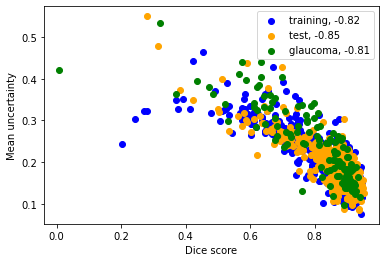

In [10]:
plot_scatter(bce_0)

In [11]:
seg_performance(bce_0)

Training:  0.83
Test:  0.84
Glaucoma:  0.78


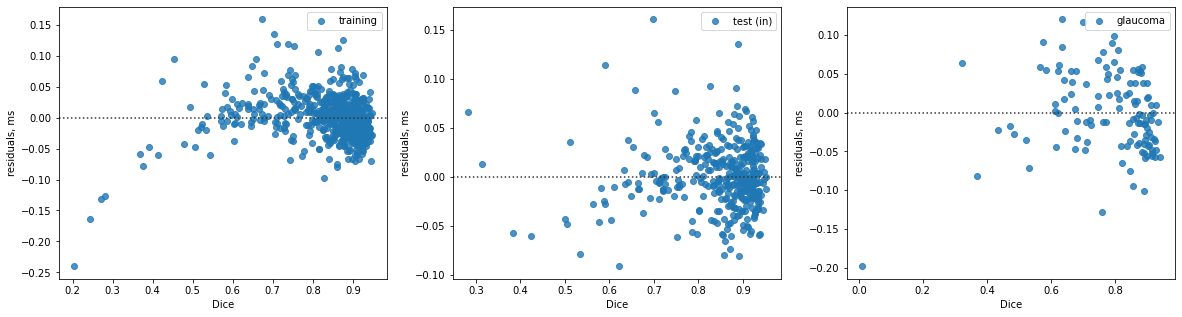

In [182]:
check_residuals(bce_0)

Coefficients: 
 [-1.4705417]
Mean squared error test: 0.0030
Mean absolute error test: 0.0409
Mean squared error glaucoma: 0.0083
Mean absolute error glaucoma: 0.0666
Coefficient of determination (in domain test): 0.72
Coefficient of determination (glaucoma): 0.63


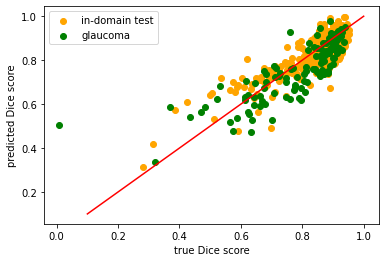

In [260]:
regression(bce_0, ["train_ms", "test_ms", "glaucoma_ms"])

Coefficients: 
 [-1.3969157]
Mean squared error glaucoma: 0.0078
Mean absolute error glaucoma: 0.0633
Coefficient of determination (glaucoma): 0.65


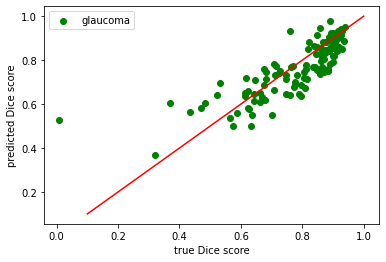

In [261]:
regression(bce_0, ["train_ms", "test_ms", "glaucoma_ms"], train_on_test=True)

##### bce ensemble

In [12]:
model_dir = "/kvh4/optic_disc/models/bce_ensemble"
eval_dict = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred"),
             "pred_dir_test": os.path.join(model_dir, "test_pred"), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred"), 
             "sampling": True}

bce_ensemble = eval_mean_uncertainty(**eval_dict)

In [107]:
np.argmin(bce_ensemble["glaucoma_dice"])

61

In [108]:
del bce_ensemble["glaucoma_dice"][61]
del bce_ensemble["glaucoma_ms"][61]
del bce_ensemble["glaucoma_pw"][61]

In [287]:
bce_ensemble_df = pd.DataFrame.from_dict(bce_ensemble, orient="index").T

bce_ensemble_df.to_excel("/kvh4/optic_disc/results/bce_ensemble.xlsx")

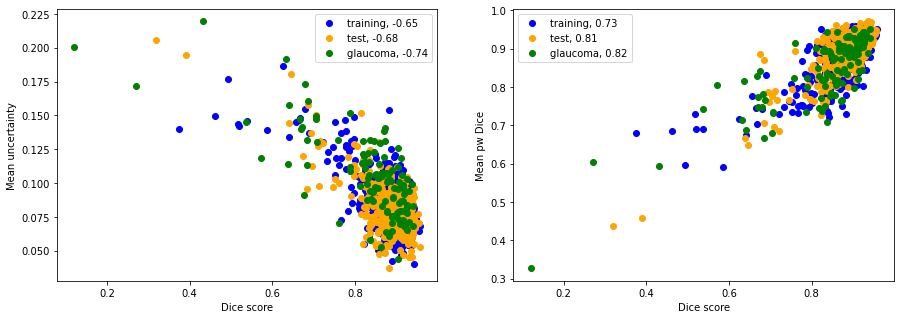

In [109]:
plot_scatter(bce_ensemble, sampling=True)

In [14]:
seg_performance(bce_ensemble)

Training:  0.88
Test:  0.88
Glaucoma:  0.83


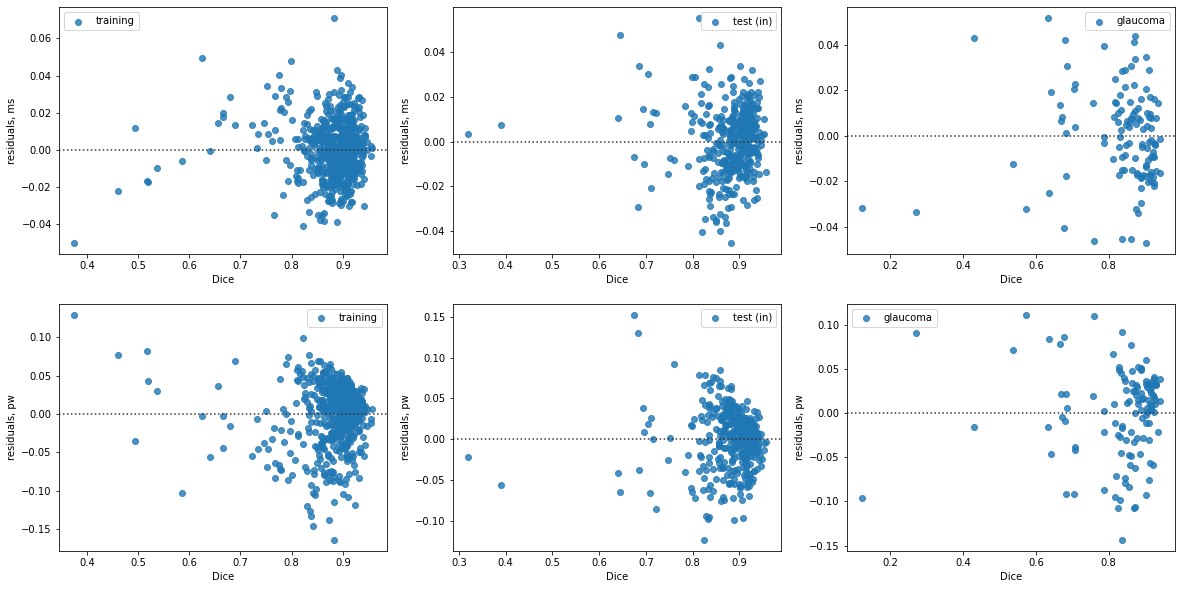

In [183]:
check_residuals(bce_ensemble, sampling=True)

Coefficients: 
 [-2.00392131]
Mean squared error test: 0.0022
Mean absolute error test: 0.0343
Mean squared error glaucoma: 0.0081
Mean absolute error glaucoma: 0.0554
Coefficient of determination (in domain test): 0.46
Coefficient of determination (glaucoma): 0.48


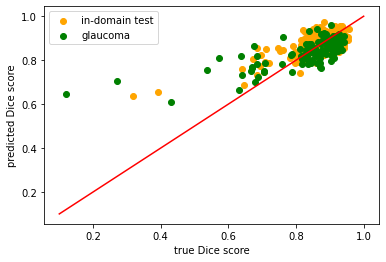

In [262]:
regression(bce_ensemble,  ["train_ms", "test_ms", "glaucoma_ms"])

Coefficients: 
 [-2.15753965]
Mean squared error glaucoma: 0.0078
Mean absolute error glaucoma: 0.0557
Coefficient of determination (glaucoma): 0.50


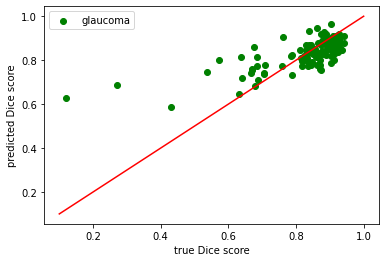

In [263]:
regression(bce_ensemble,  ["train_ms", "test_ms", "glaucoma_ms"], train_on_test=True)

Coefficients: 
 [0.78203945]
Mean squared error test: 0.0014
Mean absolute error test: 0.0274
Mean squared error glaucoma: 0.0062
Mean absolute error glaucoma: 0.0498
Coefficient of determination (in domain test): 0.65
Coefficient of determination (glaucoma): 0.60


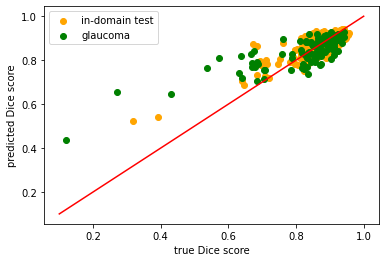

In [264]:
regression(bce_ensemble,  ["train_pw", "test_pw", "glaucoma_pw"])

Coefficients: 
 [0.83849075]
Mean squared error glaucoma: 0.0058
Mean absolute error glaucoma: 0.0494
Coefficient of determination (glaucoma): 0.63


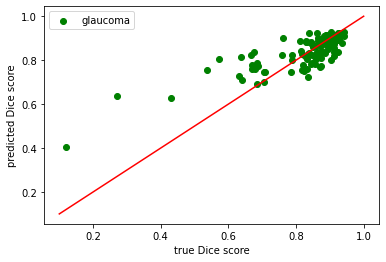

In [265]:
regression(bce_ensemble,  ["train_pw", "test_pw", "glaucoma_pw"], train_on_test=True)

Coefficients: 
 [-0.69781891  0.59644346]
Mean squared error test: 0.0014
Mean absolute error test: 0.0280
Mean squared error glaucoma: 0.0059
Mean absolute error glaucoma: 0.0494
Coefficient of determination (in domain test): 0.65
Coefficient of determination (glaucoma): 0.62


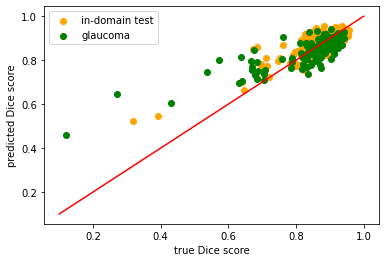

In [266]:
regression(bce_ensemble,  ["train_ms", "test_ms", "glaucoma_ms", "train_pw", "test_pw", "glaucoma_pw"])

Coefficients: 
 [-0.38468863  0.73928238]
Mean squared error glaucoma: 0.0056
Mean absolute error glaucoma: 0.0491
Coefficient of determination (glaucoma): 0.64


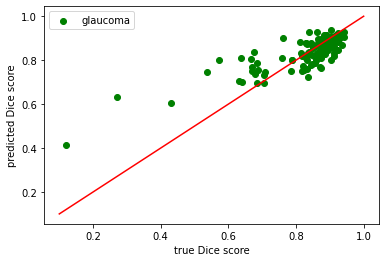

In [267]:
regression(bce_ensemble,  ["train_ms", "test_ms", "glaucoma_ms", "train_pw", "test_pw", "glaucoma_pw"], train_on_test=True)

## bce MC dropout

In [15]:
model_dir = "/kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup"
eval_dict = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_preds_epoch_175"),
             "pred_dir_test": os.path.join(model_dir, "test_preds_epoch_175"), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_preds_epoch_175"), 
             "sampling": True}

bce_MC = eval_mean_uncertainty(**eval_dict)

In [135]:
np.min(bce_MC["glaucoma_dice"])

0.06867425633492472

In [288]:
bce_MC_df = pd.DataFrame.from_dict(bce_MC, orient="index").T

bce_MC_df.to_excel("/kvh4/optic_disc/results/bce_MC.xlsx")

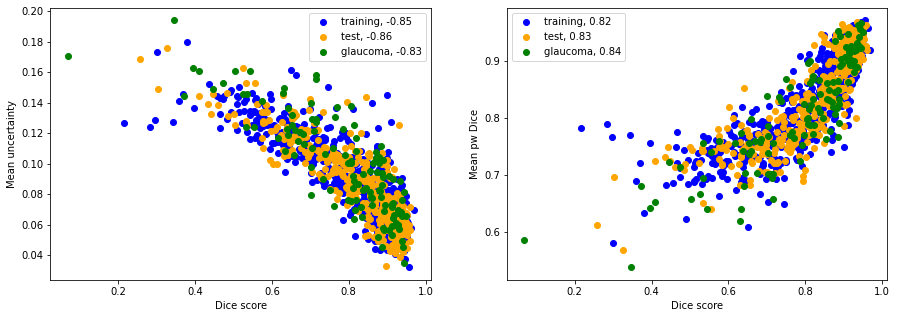

In [16]:
plot_scatter(bce_MC, sampling=True)

In [17]:
seg_performance(bce_MC)

Training:  0.8
Test:  0.81
Glaucoma:  0.78


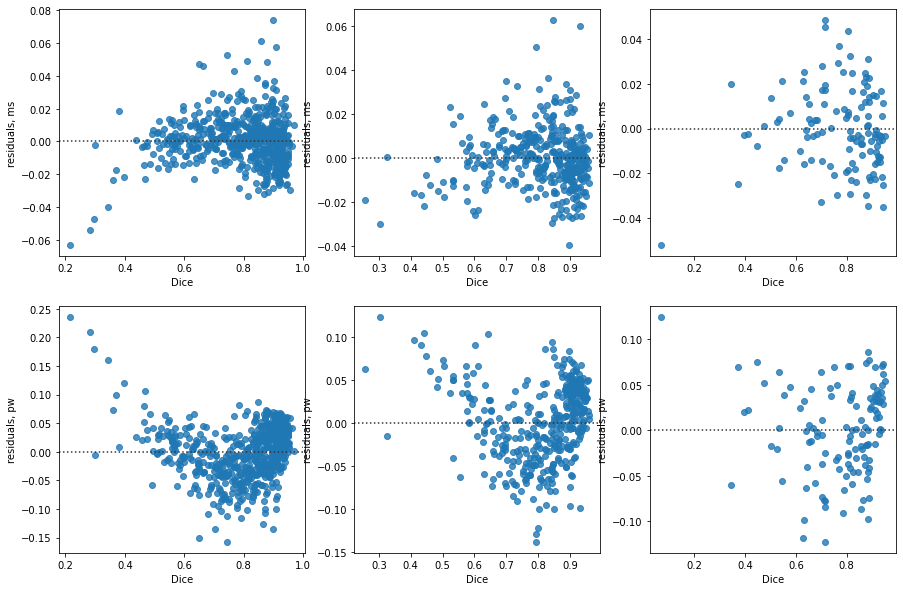

In [171]:
check_residuals(bce_MC, sampling=True)

Coefficients: 
 [-4.13536623]
Mean squared error test: 0.0042
Mean absolute error test: 0.0477
Mean squared error glaucoma: 0.0080
Mean absolute error glaucoma: 0.0682
Coefficient of determination (in domain test): 0.74
Coefficient of determination (glaucoma): 0.67


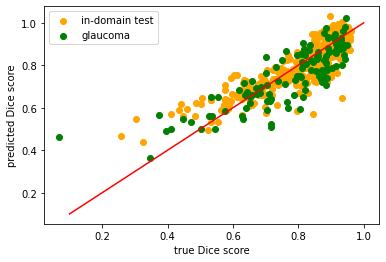

In [268]:
regression(bce_MC,  ["train_ms", "test_ms", "glaucoma_ms"])

Coefficients: 
 [-4.11107836]
Mean squared error glaucoma: 0.0078
Mean absolute error glaucoma: 0.0669
Coefficient of determination (glaucoma): 0.68


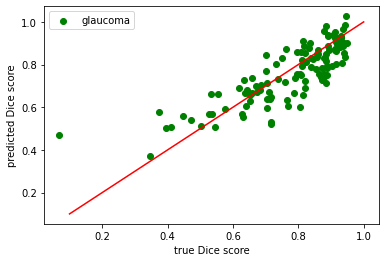

In [269]:
regression(bce_MC,  ["train_ms", "test_ms", "glaucoma_ms"], train_on_test=True)

## dice vanilla

In [18]:
model_dir = "/kvh4/optic_disc/models/dice_ensemble/00_UNet_cup"
eval_epoch = 80
eval_dict = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch)), 
             "sampling": False}

dice_0 = eval_mean_uncertainty(**eval_dict)

In [289]:
dice_0_df = pd.DataFrame.from_dict(dice_0, orient="index").T

dice_0_df.to_excel("/kvh4/optic_disc/results/dice_0.xlsx")

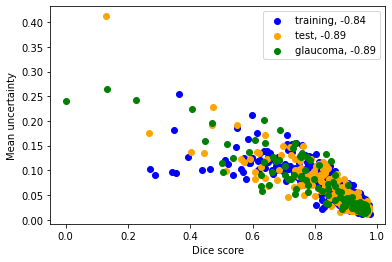

In [19]:
plot_scatter(dice_0)

In [20]:
seg_performance(dice_0)

Training:  0.88
Test:  0.89
Glaucoma:  0.81


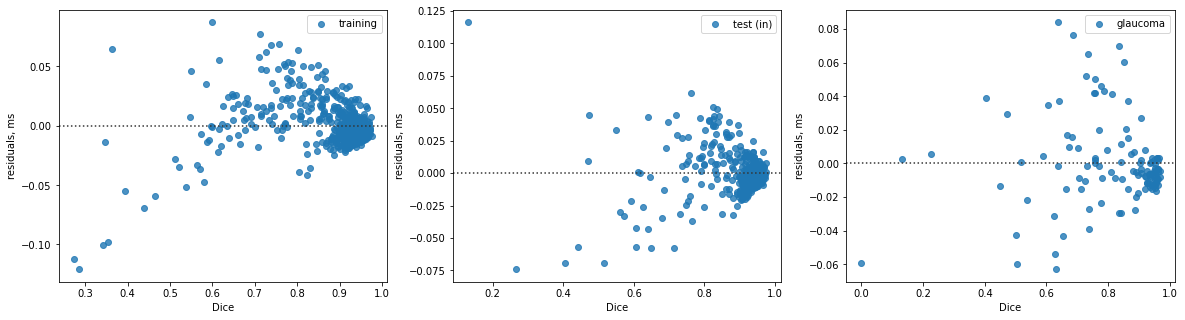

In [184]:
check_residuals(dice_0)

Coefficients: 
 [-2.5893345]
Mean squared error test: 0.0026
Mean absolute error test: 0.0321
Mean squared error glaucoma: 0.0068
Mean absolute error glaucoma: 0.0525
Coefficient of determination (in domain test): 0.78
Coefficient of determination (glaucoma): 0.78


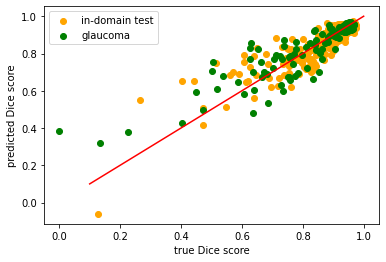

In [270]:
regression(dice_0,  ["train_ms", "test_ms", "glaucoma_ms"])

Coefficients: 
 [-2.3899012]
Mean squared error glaucoma: 0.0075
Mean absolute error glaucoma: 0.0544
Coefficient of determination (glaucoma): 0.76


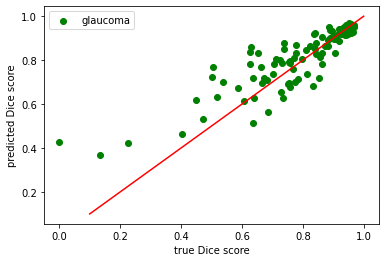

In [271]:
regression(dice_0,  ["train_ms", "test_ms", "glaucoma_ms"], train_on_test=True)

## dice ensemble

In [21]:
model_dir = "/kvh4/optic_disc/models/dice_ensemble"
eval_dict = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred"),
             "pred_dir_test": os.path.join(model_dir, "test_pred"), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred"), 
             "sampling": True}

dice_ensemble = eval_mean_uncertainty(**eval_dict)

In [22]:
np.argmin(dice_ensemble["glaucoma_dice"])

61

In [23]:
del dice_ensemble["glaucoma_dice"][61]
del dice_ensemble["glaucoma_ms"][61]
del dice_ensemble["glaucoma_pw"][61]

In [290]:
dice_ensemble_df = pd.DataFrame.from_dict(dice_ensemble, orient="index").T

dice_ensemble_df.to_excel("/kvh4/optic_disc/results/dice_ensemble.xlsx")

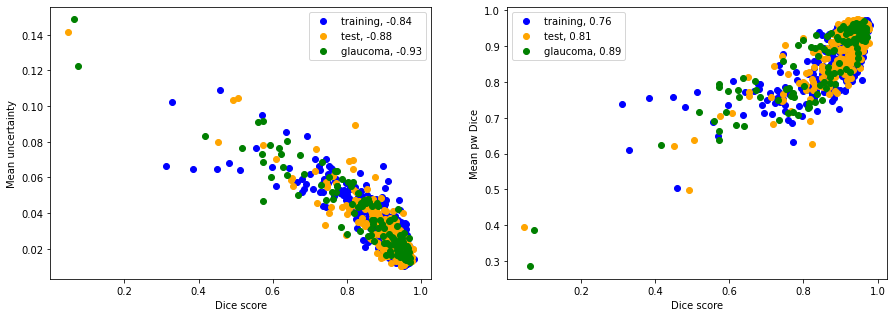

In [24]:
plot_scatter(dice_ensemble, sampling=True)

In [25]:
seg_performance(dice_ensemble)

Training:  0.91
Test:  0.91
Glaucoma:  0.83


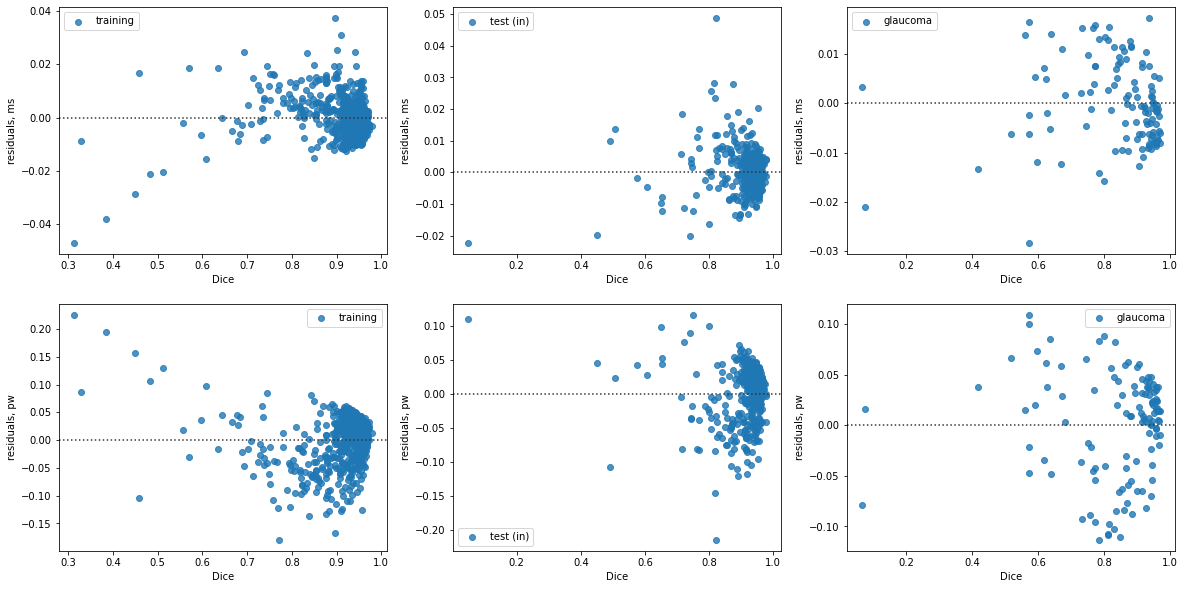

In [185]:
check_residuals(dice_ensemble, sampling=True)

Coefficients: 
 [-4.88242831]
Mean squared error test: 0.0016
Mean absolute error test: 0.0259
Mean squared error glaucoma: 0.0047
Mean absolute error glaucoma: 0.0423
Coefficient of determination (in domain test): 0.77
Coefficient of determination (glaucoma): 0.81


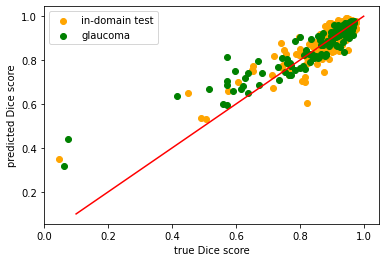

In [272]:
regression(dice_ensemble,  ["train_ms", "test_ms", "glaucoma_ms"])

Coefficients: 
 [-4.85034201]
Mean squared error glaucoma: 0.0047
Mean absolute error glaucoma: 0.0424
Coefficient of determination (glaucoma): 0.81


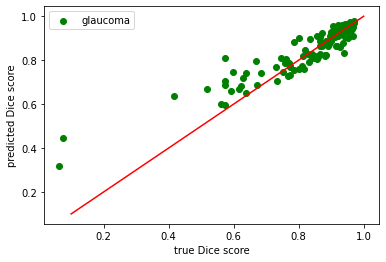

In [273]:
regression(dice_ensemble,  ["train_ms", "test_ms", "glaucoma_ms"], train_on_test=True)

Coefficients: 
 [0.89958073]
Mean squared error test: 0.0024
Mean absolute error test: 0.0324
Mean squared error glaucoma: 0.0077
Mean absolute error glaucoma: 0.0578
Coefficient of determination (in domain test): 0.65
Coefficient of determination (glaucoma): 0.69


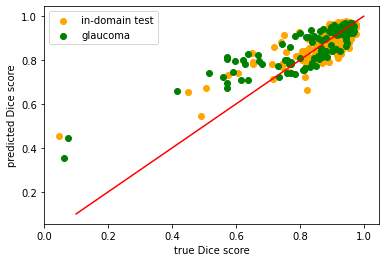

In [274]:
regression(dice_ensemble,  ["train_pw", "test_pw", "glaucoma_pw"])

Coefficients: 
 [0.91527163]
Mean squared error glaucoma: 0.0075
Mean absolute error glaucoma: 0.0574
Coefficient of determination (glaucoma): 0.70


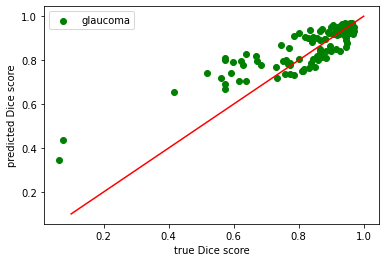

In [275]:
regression(dice_ensemble,  ["train_pw", "test_pw", "glaucoma_pw"], train_on_test=True)

Coefficients: 
 [-4.26363035  0.14336537]
Mean squared error test: 0.0016
Mean absolute error test: 0.0262
Mean squared error glaucoma: 0.0046
Mean absolute error glaucoma: 0.0426
Coefficient of determination (in domain test): 0.77
Coefficient of determination (glaucoma): 0.82


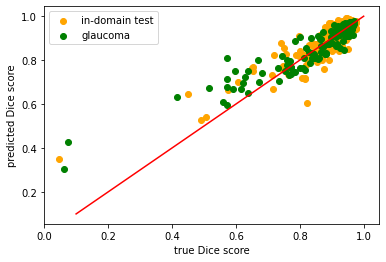

In [276]:
regression(dice_ensemble,  ["train_ms", "test_ms", "glaucoma_ms", "train_pw", "test_pw", "glaucoma_pw"])

Coefficients: 
 [-4.54130432  0.06975428]
Mean squared error glaucoma: 0.0047
Mean absolute error glaucoma: 0.0425
Coefficient of determination (glaucoma): 0.81


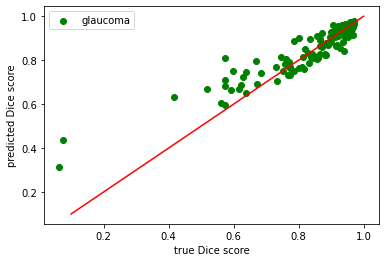

In [277]:
regression(dice_ensemble,  ["train_ms", "test_ms", "glaucoma_ms", "train_pw", "test_pw", "glaucoma_pw"], train_on_test=True)

## dice MC dropout

In [26]:
model_dir = "/kvh4/optic_disc/models/09_MC_UNet_p10_cup"
eval_dict = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_preds_epoch_193"),
             "pred_dir_test": os.path.join(model_dir, "test_preds_epoch_193"), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_preds_epoch_193"), 
             "sampling": True}

dice_MC = eval_mean_uncertainty(**eval_dict)

In [131]:
np.argmin(dice_MC["glaucoma_dice"])

61

In [132]:
del dice_MC["glaucoma_dice"][61]
del dice_MC["glaucoma_ms"][61]
del dice_MC["glaucoma_pw"][61]

In [291]:
dice_MC_df = pd.DataFrame.from_dict(dice_MC, orient="index").T

dice_MC_df.to_excel("/kvh4/optic_disc/results/dice_MC.xlsx")

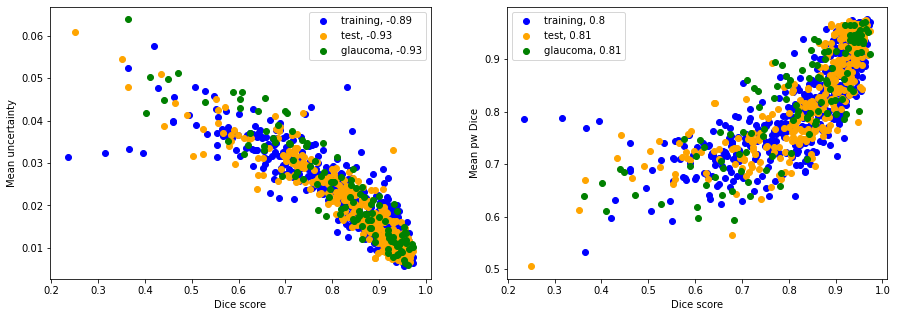

In [133]:
plot_scatter(dice_MC, sampling=True)

In [134]:
seg_performance(dice_MC)

Training:  0.85
Test:  0.85
Glaucoma:  0.81


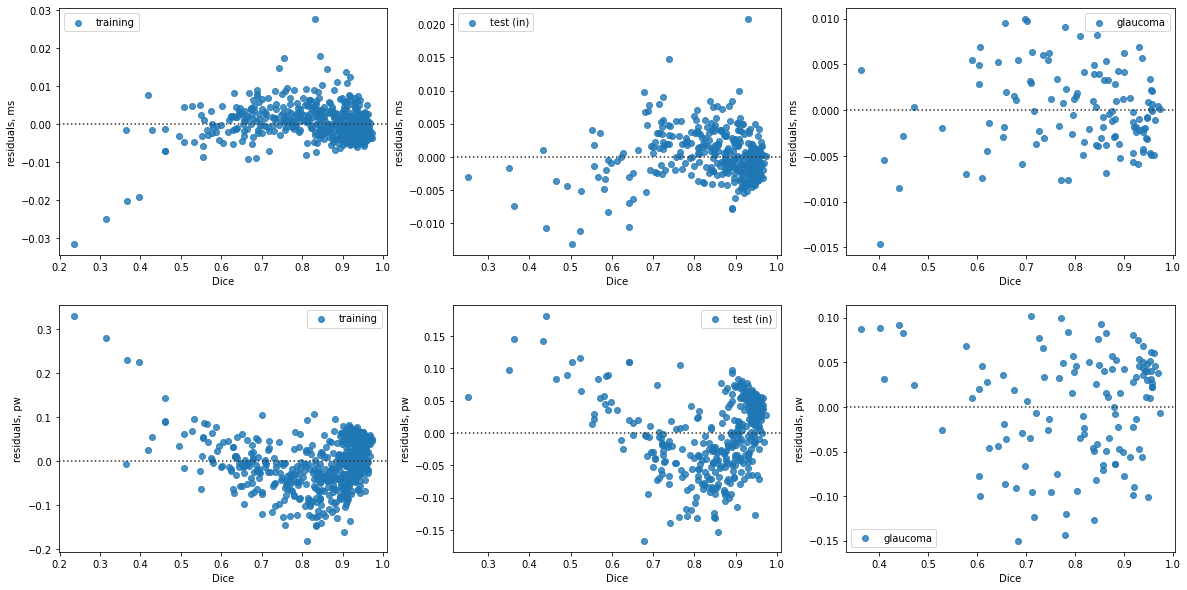

In [186]:
check_residuals(dice_MC, sampling=True)

Coefficients: 
 [-11.1420855]
Mean squared error test: 0.0020
Mean absolute error test: 0.0305
Mean squared error glaucoma: 0.0027
Mean absolute error glaucoma: 0.0405
Coefficient of determination (in domain test): 0.86
Coefficient of determination (glaucoma): 0.86


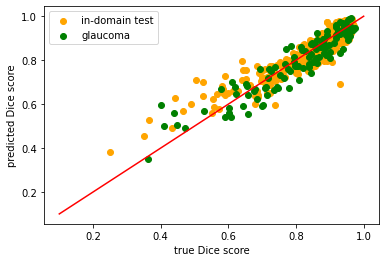

In [278]:
regression(dice_MC,  ["train_ms", "test_ms", "glaucoma_ms"])

Coefficients: 
 [-11.3768736]
Mean squared error glaucoma: 0.0028
Mean absolute error glaucoma: 0.0420
Coefficient of determination (glaucoma): 0.86


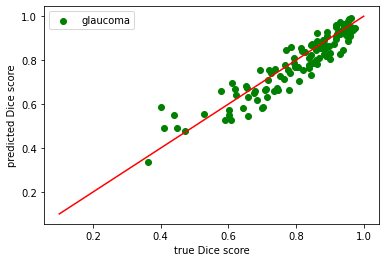

In [279]:
regression(dice_MC,  ["train_ms", "test_ms", "glaucoma_ms"], train_on_test=True)

## Regression model figure for publication

In [294]:
from cycler import cycler
CB_color_cycle = cycler(color=['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'])
mpl.rcParams['axes.prop_cycle'] = CB_color_cycle

In [301]:
plt.rcParams['font.size'] = 9
plt.rcParams['axes.linewidth'] = 1
marker_s = 4

In [319]:
def regression(eval_dict, params, train_on_test=False, legend=True):

    X_train = np.expand_dims(np.array(eval_dict[params[0]]), axis=1)
    X_test = np.expand_dims(np.array(eval_dict[params[1]]), axis=1)
    X_glaucoma = np.expand_dims(np.array(eval_dict[params[2]]), axis=1)

    if len(params)>3:
        X_train = np.concatenate((X_train, np.expand_dims(np.array(eval_dict[params[3]]), axis=1)), axis=1)
        X_test = np.concatenate((X_test, np.expand_dims(np.array(eval_dict[params[4]]), axis=1)), axis=1)
        X_glaucoma = np.concatenate((X_glaucoma, np.expand_dims(np.array(eval_dict[params[5]]), axis=1)), axis=1)
           
    y_train = np.array(eval_dict["train_dice"])
    y_test = np.array(eval_dict["test_dice"])
    y_glaucoma = np.array(eval_dict["glaucoma_dice"])

    regr = linear_model.LinearRegression()
    if not train_on_test:
        regr.fit(X_train, y_train)
    else: 
        regr.fit(X_test, y_test)

    # Make predictions using the test sets
    if not train_on_test:
        test_pred = regr.predict(X_test)
    glaucoma_pred = regr.predict(X_glaucoma)
    
    # The coefficients
    print('Coefficients: \n', regr.coef_)
    if not train_on_test:
        # The mean squared error
        print('Mean squared error test: %.4f'
              % mean_squared_error(y_test, test_pred))
        print('Mean absolute error test: %.4f'
              % mean_absolute_error(y_test, test_pred))
    print('Mean squared error glaucoma: %.4f'
          % mean_squared_error(y_glaucoma, glaucoma_pred))
    print('Mean absolute error glaucoma: %.4f'
          % mean_absolute_error(y_glaucoma, glaucoma_pred))
    # The coefficient of determination: 1 is perfect prediction
    if not train_on_test:
        print('Coefficient of determination (in domain test): %.2f'
              % r2_score(y_test, test_pred))
    print('Coefficient of determination (glaucoma): %.2f'
          % r2_score(y_glaucoma, glaucoma_pred))

    X_plot = np.linspace(0.1, 1, 100)
    plt.plot(X_plot, X_plot, color='r')
    if not train_on_test: 
        plt.scatter(y_test, test_pred, s=marker_s, color =  '#ff7f00', label="in-domain test")
    plt.scatter(y_glaucoma, glaucoma_pred, s=marker_s, color= '#4daf4a', label="domain-shifted test")
    plt.ylabel("predicted Dice score")
    plt.xlabel("true Dice score")
    # plt.ylim([0.6,1])
    # plt.xlim([0.6,1])
    plt.tight_layout()
    if legend:
        plt.legend(loc= 4, handlelength=.25)
    # plt.show()

Coefficients: 
 [-2.00392131]
Mean squared error test: 0.0022
Mean absolute error test: 0.0343
Mean squared error glaucoma: 0.0081
Mean absolute error glaucoma: 0.0554
Coefficient of determination (in domain test): 0.46
Coefficient of determination (glaucoma): 0.48
Coefficients: 
 [-2.15753965]
Mean squared error glaucoma: 0.0078
Mean absolute error glaucoma: 0.0557
Coefficient of determination (glaucoma): 0.50
Coefficients: 
 [-11.1420855]
Mean squared error test: 0.0020
Mean absolute error test: 0.0305
Mean squared error glaucoma: 0.0027
Mean absolute error glaucoma: 0.0405
Coefficient of determination (in domain test): 0.86
Coefficient of determination (glaucoma): 0.86
Coefficients: 
 [-11.3768736]
Mean squared error glaucoma: 0.0028
Mean absolute error glaucoma: 0.0420
Coefficient of determination (glaucoma): 0.86


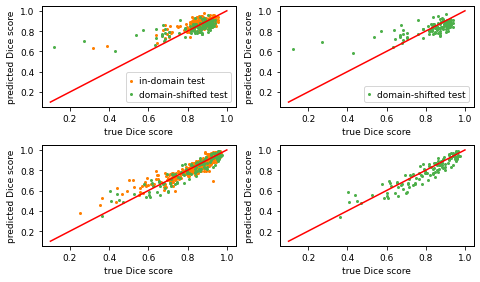

In [321]:
plt.subplots(2,2, figsize=(6.75,4))
plt.subplot(2,2,1)
regression(bce_ensemble,  ["train_ms", "test_ms", "glaucoma_ms"], legend=True)
plt.subplot(2,2,2)
regression(bce_ensemble,  ["train_ms", "test_ms", "glaucoma_ms"], train_on_test=True, legend=True)
plt.subplot(2,2,3)
regression(dice_MC,  ["train_ms", "test_ms", "glaucoma_ms"], legend=False)
plt.subplot(2,2,4)
regression(dice_MC,  ["train_ms", "test_ms", "glaucoma_ms"],train_on_test=True, legend=False)

plt.tight_layout()
plt.savefig("regression_examples_final_plot.png", dpi=600)

# Uncertainty and Strenght Distributions

In [29]:
medianprobs = dict(color="black") # ,linewidth=1.5)

## Mean Uncertainty
### Vanilla models
#### Dice

([<matplotlib.axis.XTick at 0x7f3682cce0b8>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

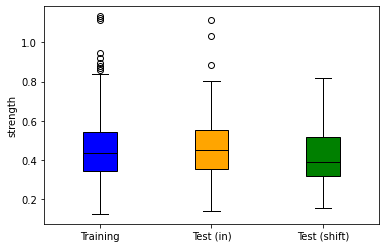

In [30]:
# with normalization
tr = np.asarray(dice_0["train_ms"]) / (1- np.asarray(dice_0["train_dice"]))
te = np.asarray(dice_0["test_ms"]) / (1- np.asarray(dice_0["test_dice"]))
g = np.asarray(dice_0["glaucoma_ms"]) / (1- np.asarray(dice_0["glaucoma_dice"]))

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("strength") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [31]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=7.594813991629962, pvalue=0.022428854633108463)

In [32]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,1.000000,0.062451
2,1.000000,1.000000,0.017976
3,0.062451,0.017976,1.000000


([<matplotlib.axis.XTick at 0x7f3682c23080>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

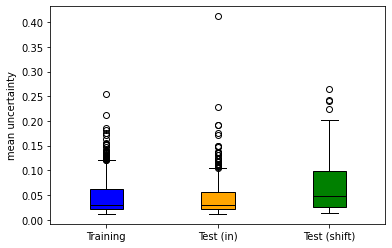

In [33]:
# without normalization
tr = np.asarray(dice_0["train_ms"]) 
te = np.asarray(dice_0["test_ms"]) 
g = np.asarray(dice_0["glaucoma_ms"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("mean uncertainty") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [34]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=19.422347879482913, pvalue=6.060252859669414e-05)

In [35]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,1.000000,0.000101
2,1.000000,1.000000,0.000079
3,0.000101,0.000079,1.000000


([<matplotlib.axis.XTick at 0x7f369336ecc0>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

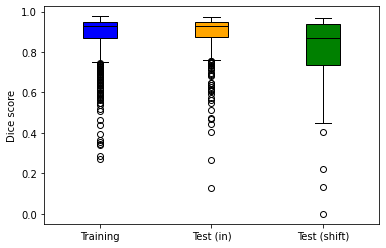

In [36]:
# without normalization
tr = np.asarray(dice_0["train_dice"]) 
te = np.asarray(dice_0["test_dice"]) 
g = np.asarray(dice_0["glaucoma_dice"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("Dice score") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [37]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=22.348237147612963, pvalue=1.4032723347588022e-05)

In [38]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,1.000000,0.000032
2,1.000000,1.000000,0.000016
3,0.000032,0.000016,1.000000


#### BCE
great example for a case where the uncertainty shifts but the strenght distribution does not

([<matplotlib.axis.XTick at 0x7f3682eb78d0>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

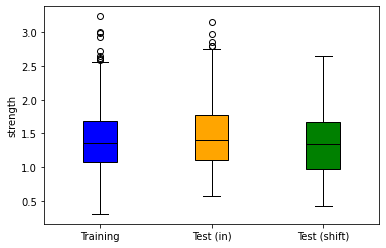

In [39]:
# with normalization
tr = np.asarray(bce_0["train_ms"]) / (1- np.asarray(bce_0["train_dice"]))
te = np.asarray(bce_0["test_ms"]) / (1- np.asarray(bce_0["test_dice"]))
g = np.asarray(bce_0["glaucoma_ms"]) / (1- np.asarray(bce_0["glaucoma_dice"]))

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("strength") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [40]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=3.9176894045863264, pvalue=0.14102124837070268)

([<matplotlib.axis.XTick at 0x7f3682fd09b0>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

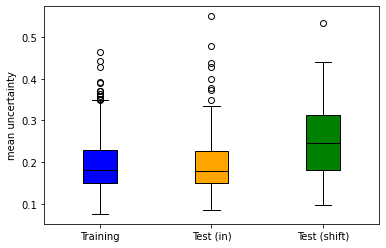

In [41]:
# without normalization
tr = np.asarray(bce_0["train_ms"]) 
te = np.asarray(bce_0["test_ms"]) 
g = np.asarray(bce_0["glaucoma_ms"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("mean uncertainty") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [42]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=46.41999733083048, pvalue=8.318129064740764e-11)

In [43]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000e+00,1.000000e+00,5.830019e-10
2,1.000000e+00,1.000000e+00,1.889435e-10
3,5.830019e-10,1.889435e-10,1.000000e+00


([<matplotlib.axis.XTick at 0x7f3693106ef0>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

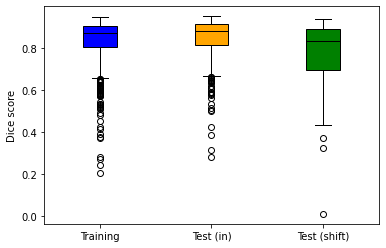

In [44]:
# without normalization
tr = np.asarray(bce_0["train_dice"]) 
te = np.asarray(bce_0["test_dice"]) 
g = np.asarray(bce_0["glaucoma_dice"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("Dice score") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [45]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=25.684201408028457, pvalue=2.646954817961962e-06)

In [46]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,0.327736,0.000066
2,0.327736,1.000000,0.000001
3,0.000066,0.000001,1.000000


### Ensemble
#### Dice

([<matplotlib.axis.XTick at 0x7f36931e4f60>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

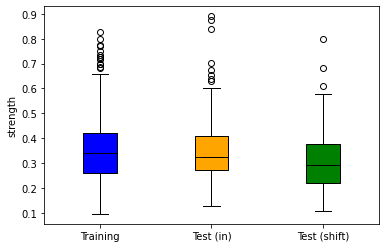

In [47]:
# with normalization
tr = np.asarray(dice_ensemble["train_ms"]) / (1- np.asarray(dice_ensemble["train_dice"]))
te = np.asarray(dice_ensemble["test_ms"]) / (1- np.asarray(dice_ensemble["test_dice"]))
g = np.asarray(dice_ensemble["glaucoma_ms"]) / (1- np.asarray(dice_ensemble["glaucoma_dice"]))

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("strength") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [48]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=14.852926293202017, pvalue=0.0005952892437428704)

In [49]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,0.870627,0.000350
2,0.870627,1.000000,0.007568
3,0.000350,0.007568,1.000000


([<matplotlib.axis.XTick at 0x7f36932e2c18>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

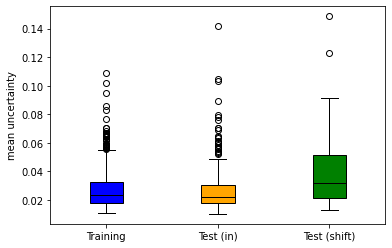

In [50]:
# without normalization
tr = np.asarray(dice_ensemble["train_ms"]) 
te = np.asarray(dice_ensemble["test_ms"]) 
g = np.asarray(dice_ensemble["glaucoma_ms"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("mean uncertainty") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [51]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=35.80960570969455, pvalue=1.6751084159205112e-08)

In [52]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000e+00,1.000000e+00,1.139898e-07
2,1.000000e+00,1.000000e+00,1.895858e-08
3,1.139898e-07,1.895858e-08,1.000000e+00


([<matplotlib.axis.XTick at 0x7f3682ed3c50>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

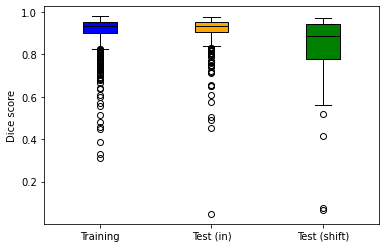

In [53]:
# without normalization
tr = np.asarray(dice_ensemble["train_dice"]) 
te = np.asarray(dice_ensemble["test_dice"]) 
g = np.asarray(dice_ensemble["glaucoma_dice"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("Dice score") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [54]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=31.254458341030716, pvalue=1.633731202975728e-07)

In [55]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000e+00,1.000000,1.065545e-07
2,1.000000e+00,1.000000,2.131620e-06
3,1.065545e-07,0.000002,1.000000e+00


#### BCE
great example for a case where the uncertainty shifts but the strenght distribution does not

([<matplotlib.axis.XTick at 0x7f36820bda58>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

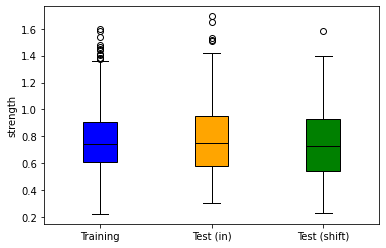

In [110]:
# with normalization
tr = np.asarray(bce_ensemble["train_ms"]) / (1- np.asarray(bce_ensemble["train_dice"]))
te = np.asarray(bce_ensemble["test_ms"]) / (1- np.asarray(bce_ensemble["test_dice"]))
g = np.asarray(bce_ensemble["glaucoma_ms"]) / (1- np.asarray(bce_ensemble["glaucoma_dice"]))

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("strength") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [111]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=0.5311461188430258, pvalue=0.766766421328026)

([<matplotlib.axis.XTick at 0x7f3671f8afd0>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

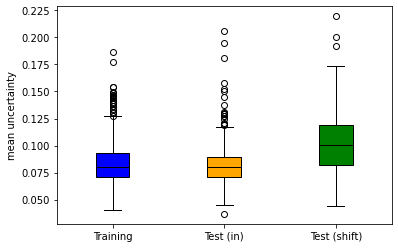

In [112]:
# without normalization
tr = np.asarray(bce_ensemble["train_ms"]) 
te = np.asarray(bce_ensemble["test_ms"]) 
g = np.asarray(bce_ensemble["glaucoma_ms"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("mean uncertainty") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [113]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=64.7891772007547, pvalue=8.535106161439225e-15)

In [114]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000e+00,1.000000e+00,1.991102e-13
2,1.000000e+00,1.000000e+00,2.824457e-14
3,1.991102e-13,2.824457e-14,1.000000e+00


([<matplotlib.axis.XTick at 0x7f36931785f8>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

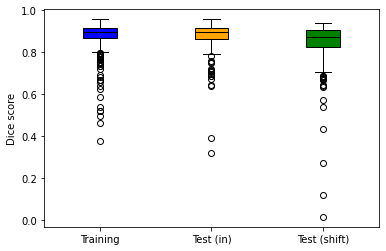

In [61]:
# without normalization
tr = np.asarray(bce_ensemble["train_dice"]) 
te = np.asarray(bce_ensemble["test_dice"]) 
g = np.asarray(bce_ensemble["glaucoma_dice"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("Dice score") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [62]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=25.144516041528277, pvalue=3.4668712744037374e-06)

In [63]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,1.000000,0.000015
2,1.000000,1.000000,0.000003
3,0.000015,0.000003,1.000000


### MC Dropout
#### Dice

([<matplotlib.axis.XTick at 0x7f3671b382b0>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

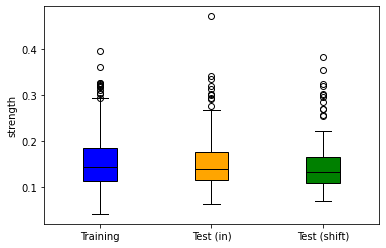

In [136]:
# with normalization
tr = np.asarray(dice_MC["train_ms"]) / (1- np.asarray(dice_MC["train_dice"]))
te = np.asarray(dice_MC["test_ms"]) / (1- np.asarray(dice_MC["test_dice"]))
g = np.asarray(dice_MC["glaucoma_ms"]) / (1- np.asarray(dice_MC["glaucoma_dice"]))

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("strength") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [137]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=3.9034040776082293, pvalue=0.14203212155843165)

([<matplotlib.axis.XTick at 0x7f3671a103c8>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

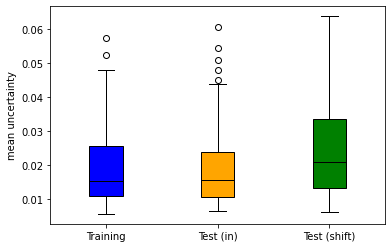

In [138]:
# without normalization
tr = np.asarray(dice_MC["train_ms"]) 
te = np.asarray(dice_MC["test_ms"]) 
g = np.asarray(dice_MC["glaucoma_ms"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("mean uncertainty") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [139]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=21.20735106817392, pvalue=2.4824598184463285e-05)

In [140]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,0.840465,0.000149
2,0.840465,1.000000,0.000016
3,0.000149,0.000016,1.000000


([<matplotlib.axis.XTick at 0x7f367199d6d8>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

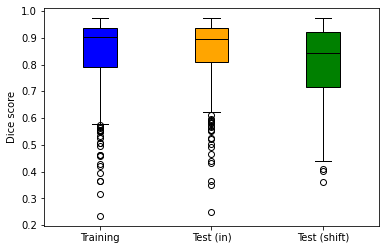

In [141]:
# without normalization
tr = np.asarray(dice_MC["train_dice"]) 
te = np.asarray(dice_MC["test_dice"]) 
g = np.asarray(dice_MC["glaucoma_dice"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("Dice score") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [142]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=13.392470077537837, pvalue=0.001235554973271722)

In [143]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,1.000000,0.001172
2,1.000000,1.000000,0.002236
3,0.001172,0.002236,1.000000


#### BCE
great example for a case where the uncertainty shifts but the strenght distribution does not

([<matplotlib.axis.XTick at 0x7f368296c0f0>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

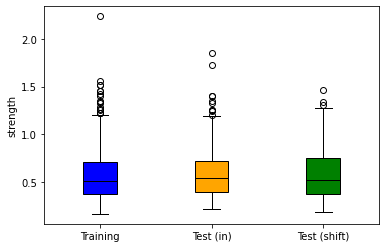

In [72]:
# with normalization
tr = np.asarray(bce_MC["train_ms"]) / (1- np.asarray(bce_MC["train_dice"]))
te = np.asarray(bce_MC["test_ms"]) / (1- np.asarray(bce_MC["test_dice"]))
g = np.asarray(bce_MC["glaucoma_ms"]) / (1- np.asarray(bce_MC["glaucoma_dice"]))

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("strength") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [73]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=1.7459329587277352, pvalue=0.41771057968767533)

([<matplotlib.axis.XTick at 0x7f36828f3710>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

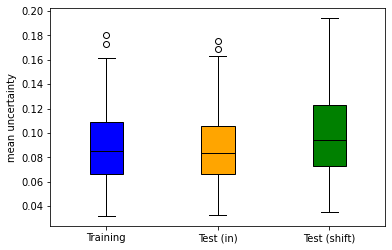

In [74]:
# without normalization
tr = np.asarray(bce_MC["train_ms"]) 
te = np.asarray(bce_MC["test_ms"]) 
g = np.asarray(bce_MC["glaucoma_ms"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("mean uncertainty") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [75]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=11.117202259797978, pvalue=0.0038541641033102724)

In [76]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,1.000000,0.005924
2,1.000000,1.000000,0.003917
3,0.005924,0.003917,1.000000


([<matplotlib.axis.XTick at 0x7f368280e278>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

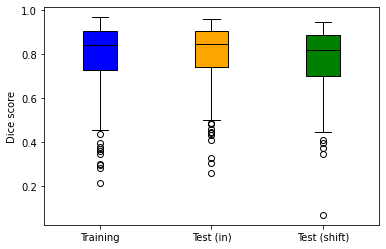

In [77]:
# without normalization
tr = np.asarray(bce_MC["train_dice"]) 
te = np.asarray(bce_MC["test_dice"]) 
g = np.asarray(bce_MC["glaucoma_dice"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("Dice score") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [78]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=3.6672937659977833, pvalue=0.1598296236971199)

## Mean Pairwise Dice
### Ensemble
#### Dice

([<matplotlib.axis.XTick at 0x7f3682e096d8>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

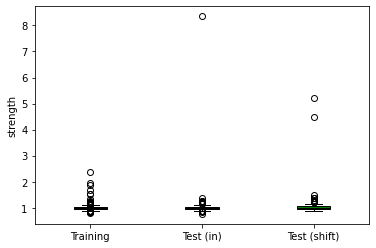

In [99]:
# with normalization
tr = np.asarray(dice_ensemble["train_pw"]) / (np.asarray(dice_ensemble["train_dice"]))
te = np.asarray(dice_ensemble["test_pw"]) / ( np.asarray(dice_ensemble["test_dice"]))
g = np.asarray(dice_ensemble["glaucoma_pw"]) / ( np.asarray(dice_ensemble["glaucoma_dice"]))

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("strength") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [100]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=6.678735116630378, pvalue=0.03545937661942015)

In [101]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,0.983955,0.031237
2,0.983955,1.000000,0.198734
3,0.031237,0.198734,1.000000


([<matplotlib.axis.XTick at 0x7f3682ead668>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

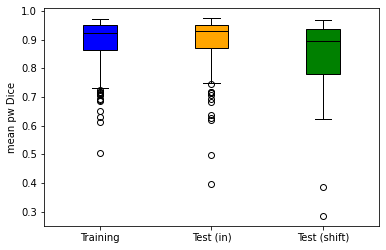

In [102]:
# without normalization
tr = np.asarray(dice_ensemble["train_pw"]) 
te = np.asarray(dice_ensemble["test_pw"]) 
g = np.asarray(dice_ensemble["glaucoma_pw"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("mean pw Dice") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [83]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=27.46001276141942, pvalue=1.0892661114763973e-06)

In [84]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,1.000000,0.000004
2,1.000000,1.000000,0.000001
3,0.000004,0.000001,1.000000


([<matplotlib.axis.XTick at 0x7f368226eef0>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

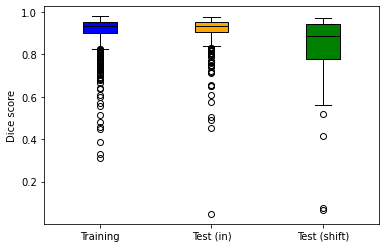

In [103]:
# without normalization
tr = np.asarray(dice_ensemble["train_dice"]) 
te = np.asarray(dice_ensemble["test_dice"]) 
g = np.asarray(dice_ensemble["glaucoma_dice"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("Dice score") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [104]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=31.254458341030716, pvalue=1.633731202975728e-07)

In [105]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000e+00,1.000000,1.065545e-07
2,1.000000e+00,1.000000,2.131620e-06
3,1.065545e-07,0.000002,1.000000e+00


#### BCE
great example for a case where the uncertainty shifts but the strenght distribution does not

([<matplotlib.axis.XTick at 0x7f3671dc3b38>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

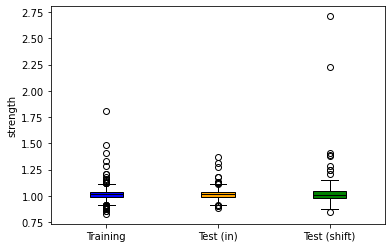

In [119]:
# with normalization
tr = np.asarray(bce_ensemble["train_pw"]) / (np.asarray(bce_ensemble["train_dice"]))
te = np.asarray(bce_ensemble["test_pw"]) / ( np.asarray(bce_ensemble["test_dice"]))
g = np.asarray(bce_ensemble["glaucoma_pw"]) / ( np.asarray(bce_ensemble["glaucoma_dice"]))

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("strength") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [120]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=0.6737998697117291, pvalue=0.7139802808680002)

([<matplotlib.axis.XTick at 0x7f3671d60748>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

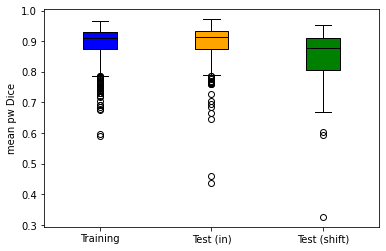

In [121]:
# without normalization
tr = np.asarray(bce_ensemble["train_pw"]) 
te = np.asarray(bce_ensemble["test_pw"]) 
g = np.asarray(bce_ensemble["glaucoma_pw"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("mean pw Dice") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [122]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=39.38729855412248, pvalue=2.7999919995826673e-09)

In [123]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000e+00,1.000000e+00,1.557663e-08
2,1.000000e+00,1.000000e+00,4.556000e-09
3,1.557663e-08,4.556000e-09,1.000000e+00


([<matplotlib.axis.XTick at 0x7f3671c76390>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

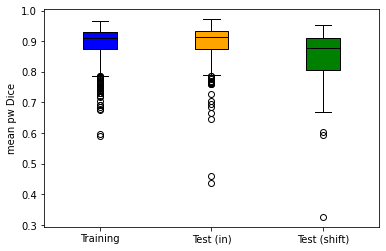

In [124]:
# without normalization
tr = np.asarray(bce_ensemble["train_pw"]) 
te = np.asarray(bce_ensemble["test_pw"]) 
g = np.asarray(bce_ensemble["glaucoma_pw"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("mean pw Dice") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [125]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=39.38729855412248, pvalue=2.7999919995826673e-09)

In [126]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000e+00,1.000000e+00,1.557663e-08
2,1.000000e+00,1.000000e+00,4.556000e-09
3,1.557663e-08,4.556000e-09,1.000000e+00


### MC Dropout
#### Dice

([<matplotlib.axis.XTick at 0x7f36718b4f60>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

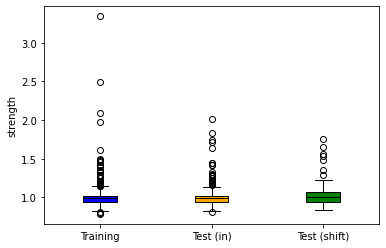

In [144]:
# with normalization
tr = np.asarray(dice_MC["train_pw"]) / ( np.asarray(dice_MC["train_dice"]))
te = np.asarray(dice_MC["test_pw"]) / ( np.asarray(dice_MC["test_dice"]))
g = np.asarray(dice_MC["glaucoma_pw"]) / ( np.asarray(dice_MC["glaucoma_dice"]))

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("strength") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [145]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=5.330745178471261, pvalue=0.06957342639372217)

([<matplotlib.axis.XTick at 0x7f3671843710>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

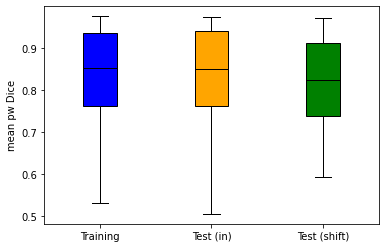

In [146]:
# without normalization
tr = np.asarray(dice_MC["train_pw"]) 
te = np.asarray(dice_MC["test_pw"]) 
g = np.asarray(dice_MC["glaucoma_pw"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("mean pw Dice") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [147]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=8.071460534655216, pvalue=0.017672769553479975)

In [148]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,1.000000,0.033006
2,1.000000,1.000000,0.015708
3,0.033006,0.015708,1.000000


([<matplotlib.axis.XTick at 0x7f3671765828>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

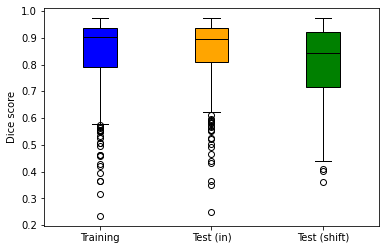

In [152]:
# without normalization
tr = np.asarray(dice_MC["train_dice"]) 
te = np.asarray(dice_MC["test_dice"]) 
g = np.asarray(dice_MC["glaucoma_dice"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("Dice score") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [153]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=13.392470077537837, pvalue=0.001235554973271722)

In [154]:
posthoc_dunn([tr, te, g], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,1.000000,0.001172
2,1.000000,1.000000,0.002236
3,0.001172,0.002236,1.000000


#### BCE
great example for a case where the uncertainty shifts but the strenght distribution does not

([<matplotlib.axis.XTick at 0x7f3671685208>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

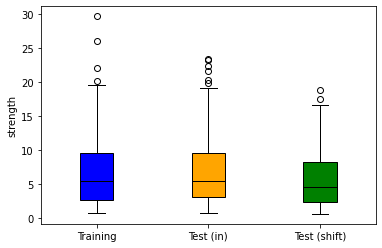

In [155]:
# with normalization
tr = np.asarray(bce_MC["train_pw"]) / (1- np.asarray(bce_MC["train_dice"]))
te = np.asarray(bce_MC["test_pw"]) / (1- np.asarray(bce_MC["test_dice"]))
g = np.asarray(bce_MC["glaucoma_pw"]) / (1- np.asarray(bce_MC["glaucoma_dice"]))

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("strength") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [156]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=4.102537515698714, pvalue=0.12857167373986295)

([<matplotlib.axis.XTick at 0x7f3671614128>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

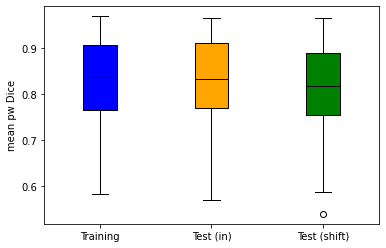

In [157]:
# without normalization
tr = np.asarray(bce_MC["train_pw"]) 
te = np.asarray(bce_MC["test_pw"]) 
g = np.asarray(bce_MC["glaucoma_pw"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("mean pw Dice") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [158]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=5.913176146956175, pvalue=0.051996021472183)

([<matplotlib.axis.XTick at 0x7f36715977f0>,
 [Text(1, 0, 'Training'), Text(2, 0, 'Test (in)'), Text(3, 0, 'Test (shift)')])

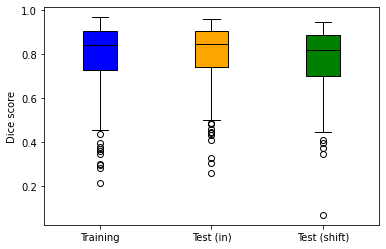

In [159]:
# without normalization
tr = np.asarray(bce_MC["train_dice"]) 
te = np.asarray(bce_MC["test_dice"]) 
g = np.asarray(bce_MC["glaucoma_dice"]) 

box = plt.boxplot([tr, te,g] , patch_artist=True ,medianprops=medianprobs)
colors = ['blue', 'orange', "green"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("Dice score") 
plt.xticks([1, 2, 3], ['Training', 'Test (in)', 'Test (shift)'],rotation=0)

In [160]:
kruskalwallis(tr,te,g)

KruskalResult(statistic=3.6672937659977833, pvalue=0.1598296236971199)